# Objekttracking mit Segmentierung mit lokalem Schwellwert und Tracking über eine Kostenfunktion

In diesem Notebook wird untersucht, wie gut ein Objekttracking mit einer Segmentierung über einen lokal bestimmten Schwellwert und dem Finden des des zugehörigen nächsten Objektes über eine Kostenfunktion nach Laskhmanan & Shmith (2010) funktioniert.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
%matplotlib inline

from standard_config import *
import sys
sys.path.append("{}/utils/tracking".format(local_home_path))
import object_tracking as ot
import segmentation as oseg

from plotting_tools.colormaps import enhanced_colormap
emap = enhanced_colormap()
from plotting_tools.colormaps import radar_cmap as rc

from IPython.display import display, Image
import ipywidgets as widgets
from ipywidgets import HBox, VBox

from scipy import ndimage as ndi

import glob
import tqdm

/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


## 1. HACI-Track für 2013 laden

Wir Laden uns die HACI-Tracks für das Jahr 2013 als Beispiele.

In [2]:
haci_track_data_path = "{}/HACI_track_data/".format(local_data_path)
haci_bbox_data_path = "{}/HACI_bbox_data/".format(local_data_path)
haci_track_interest_field_path = "{}/HACI_track_interest_field_data/".format(local_data_path)

In [3]:
haci_tracks_2013 = glob.glob("{}/track_2013*.nc".format(haci_track_data_path))

In [4]:
def read_nc_file(filename):
    data = {}
    
    with xr.open_dataset(filename) as f:
        for d in f.data_vars:
            data[d] = f[d].data.copy()
        for d in f.coords:
            data[d] = f.coords[d].data.copy()
    return data

def extract_track_id_from_file_name(filename):
    return filename.split("/")[-1].split(".")[0][6:]

### 1.1 Ein Beispiel

In [5]:
example_data = read_nc_file(haci_tracks_2013[0])
track_id = extract_track_id_from_file_name(haci_tracks_2013[0])

Als nächstes sehen wir uns diesen Fall mal an.


In [6]:
def plot_haci_case(case_data):
    fig,ax = plt.subplots(4,4,figsize=(16,16),sharex=True,sharey=True)
    axs = ax.ravel()

    for i,ir in enumerate(case_data['ir108']):
        p = axs[i].pcolormesh(case_data['slon'],case_data['slat'],ir,vmin=210,vmax=300,cmap=emap)
        p1 = axs[i].contourf(case_data['rlon'],
                             case_data['rlat'],
                             np.ma.masked_greater(np.ma.masked_less(case_data['rx'][i],5),70),
                             np.arange(5,75,5),
                             vmin=5,vmax=70,cmap=rc(),
                             alpha=0.5)
        axs[i].set_title("{}, {} min".format(np.datetime_as_string(case_data['time'][i],
                                                               unit='m',
                                                               timezone='UTC'),
                                                               (i*5)-30))

    cbar1 = fig.colorbar(p1, ax=ax.flat,orientation='horizontal')
    cbar1.ax.set_title(u'RX / dBZ')

    cbar = fig.colorbar(p, ax=ax.flat)
    cbar.ax.set_title(r'$T_\mathrm{B}$(10.8 µm)')
    
    plt.title("Track {}".format(track_id))
    for i in range(13,16):
        fig.delaxes(axs[i])
    return fig

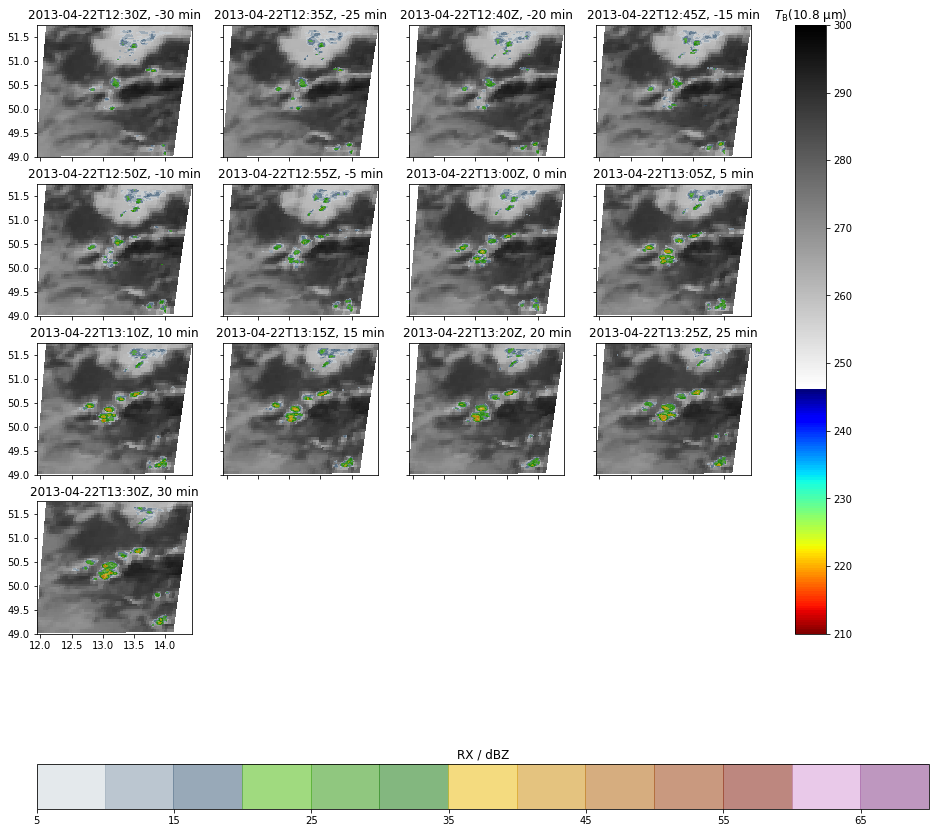

In [24]:
example_plot = plot_haci_case(example_data)

### 1.1.1 Objekt finden

In [7]:
obj = np.array([oseg.segment_local_threshold(ir,minimum_depth=10,spread=5) for ir in example_data['ir108']])

In [8]:
def plot_haci_sat_object(case_data,objects):
    fig,ax = plt.subplots(4,4,figsize=(16,16),sharex=True,sharey=True)
    axs = ax.ravel()

    for i,ir in enumerate(case_data['ir108']):
        p = axs[i].imshow(ir,vmin=210,vmax=300,cmap=emap)
        axs[i].imshow(np.ma.masked_less(objects[i],1),
                      alpha=0.4,vmin=1,vmax=np.max(np.unique(objects)))

        axs[i].set_title("{}, {} min".format(np.datetime_as_string(case_data['time'][i],
                                                                   unit='m',
                                                                   timezone='UTC'),
                                                                   (i*5)-30))

    cbar = fig.colorbar(p, ax=ax.flat)
    cbar.ax.set_title(u'BT(10.8 µm)')
    
    plt.title("Track {}".format(track_id))
    for i in range(13,16):
        fig.delaxes(axs[i])
    return fig

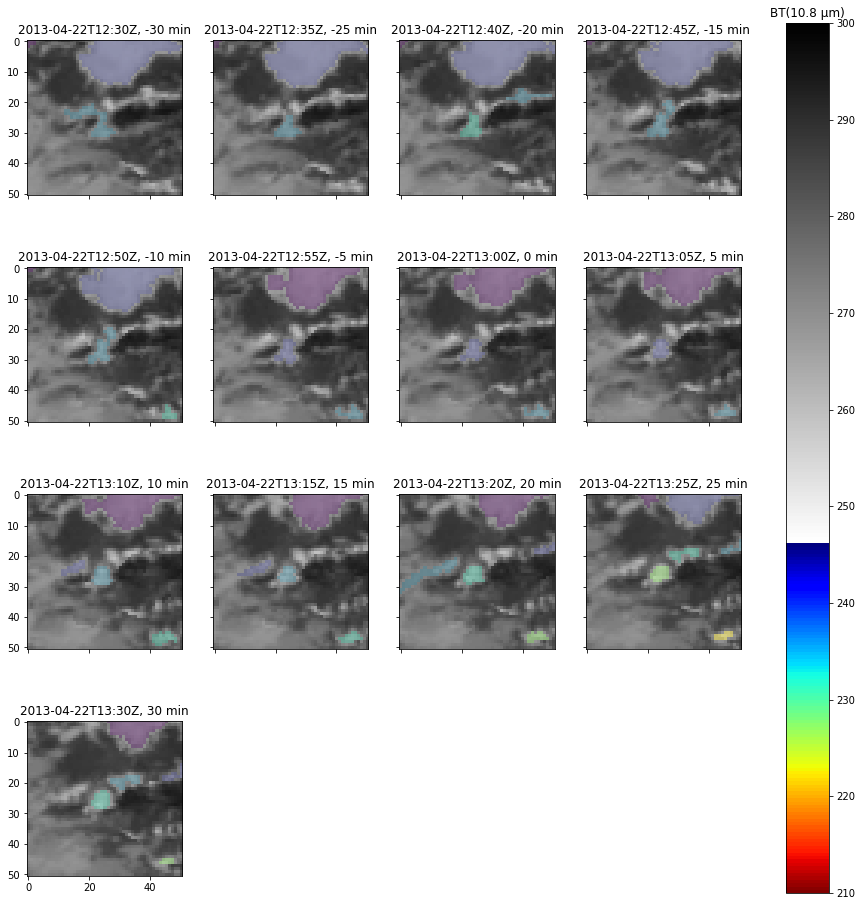

In [9]:
example_obj_plot = plot_haci_sat_object(example_data,obj)

### 1.1.2 Objekttrack für das zum HACI-Objekt gehörende Satellitenobjekt ermitteln

In [65]:
object_track = ot.get_track_from_labeled_field(obj,method='cost')

In [66]:
print(sorted(object_track))

['000_0003', '001_0003', '002_0004', '003_0003', '004_0003', '005_0002', '006_0002', '007_0002', '008_0003', '009_0003', '010_0004', '011_0005', '012_0004']


Das sieht soweit vernünftig aus. Außer für den ersten Zeitschritt. Da wird der Hintergrund als Objekt ausgewählt.

In [47]:
centroids_t0, areas_t0, diameters_t0 = ot.get_object_properties(obj[0])
centroids_t1, areas_t1, diameters_t1 = ot.get_object_properties(obj[1])

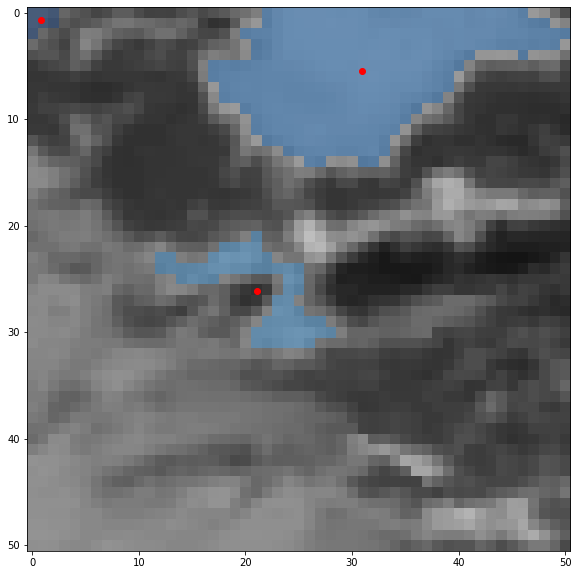

In [60]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(example_data['ir108'][0],vmin=210,vmax=300,cmap=emap)
ax.imshow(np.ma.masked_less(obj[0],1),alpha=0.5,cmap='Blues_r',vmin=1,vmax=8)

for ic,c in enumerate(centroids_t0):
    ax.plot(c[1],c[0],'ro')

Das Problem ist hier, dass der Schwerpunkt des Objektes außerhalb des eigentlichen Objektes liegt!

In [56]:
from skimage.measure import regionprops

In [63]:
from importlib import reload

In [64]:
reload(ot)

<module 'object_tracking' from '/vols/satellite/home/lenk/utils/tracking/object_tracking.py'>

In [ ]:
regions = regionprops()

In [61]:
np.unique(obj[0])

array([0, 1, 2, 3], dtype=uint16)

In [ ]:
for i,c in enumerate(centroids_t0):
    print("i={}, c={}".format(i,c))

Das konnte durch eine Anpassung dessen, wie die Zugehörigkeit zu einem Objekt ermittelt wird, gelöst werden.

In [67]:
wanted_object = ot.get_wanted_object_field(obj,sorted(object_track))

In [68]:
wanted_object

{0: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint16),
 1: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint16),
 2: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint16),
 3: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint16),
 4: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0,

## Objektdefinition

Bei der Zuordnung der Objekte in der Objektdefinition passiert es manchmal, dass ein Objekt von einem anderen umgeben ist. 